### Validating Multi-view KMeans Clustering on Simulated Data

In [1]:
import numpy as np
from numpy.random import multivariate_normal
from multiview.cluster.mv_k_means import MultiviewKMeans
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score as nmi_score
import matplotlib.pyplot as plt

RANDOM_SEED=10

##### A function to generate 2 views of data for 2 classes

This function takes parameters for means, variances, and number of samples for class and generates data based on those parameters. The underlying probability distribution of the data is a multivariate gaussian distribution.

In [2]:
def create_data(seed, vmeans, vvars, num_per_class=500):
    
    np.random.seed(seed)
    data = [[],[]]
    
    for view in range(2):
        for comp in range(len(vmeans[0])):
            cov = np.eye(2) * vvars[view][comp]
            comp_samples = np.random.multivariate_normal(vmeans[view][comp], cov, size=num_per_class)
            data[view].append(comp_samples)
    for view in range(2):
        data[view] = np.vstack(data[view])
    
    labels = list()
    for ind in range(len(vmeans[0])):
        labels.append(ind * np.ones(num_per_class,))
    
    labels = np.concatenate(labels)
    
    return data, labels

##### Creating a function to display data and the results of clustering

The following function plots both views of data given a dataset and corresponding labels.

In [3]:
def display_plots(pre_title, data, labels):
    
    # plot the views
    plt.figure()
    fig, ax = plt.subplots(1,2, figsize=(14,5))
    dot_size=10
    ax[0].scatter(data[0][:, 0], data[0][:, 1],c=labels,s=dot_size)
    ax[0].set_title(pre_title + ' View 1')
    ax[0].axes.get_xaxis().set_visible(False)
    ax[0].axes.get_yaxis().set_visible(False)

    ax[1].scatter(data[1][:, 0], data[1][:, 1],c=labels,s=dot_size)
    ax[1].set_title(pre_title + ' View 2')
    ax[1].axes.get_xaxis().set_visible(False)
    ax[1].axes.get_yaxis().set_visible(False)

    plt.show()

##### Creating a function to perform both single-view and multi-view kmeans clustering

In the following function, we will perform single-view kmeans clustering on the two views separately and on them concatenated together. We also perform multi-view clustering using the multi-view algorithm. We will also compare the performance of multi-view and single-view versions of kmeans clustering. We will evaluate the purity of the resulting clusters from each algorithm with respect to the class labels using the normalized mutual information metric.

In [4]:
def perform_clustering(seed, m_data, labels, n_clusters):
    #################Single-view kmeans clustering#####################
    # Cluster each view separately
    s_kmeans = KMeans(n_clusters=n_clusters, random_state=seed, n_init=100)
    s_clusters_v1 = s_kmeans.fit_predict(m_data[0])
    s_clusters_v2 = s_kmeans.fit_predict(m_data[1])

    # Concatenate the multiple views into a single view
    s_data = np.hstack(m_data)
    s_clusters = s_kmeans.fit_predict(s_data)

    # Compute nmi between true class labels and single-view cluster labels
    s_nmi_v1 = nmi_score(labels, s_clusters_v1)
    s_nmi_v2 = nmi_score(labels, s_clusters_v2)
    s_nmi = nmi_score(labels, s_clusters)
    print('Single-view View 1 NMI Score: {0:.3f}\n'.format(s_nmi_v1))
    print('Single-view View 2 NMI Score: {0:.3f}\n'.format(s_nmi_v2))
    print('Single-view Concatenated NMI Score: {0:.3f}\n'.format(s_nmi))

    #################Multi-view kmeans clustering######################

    # Use the MultiviewKMeans instance to cluster the data
    m_kmeans = MultiviewKMeans(n_clusters=n_clusters, n_init=100, random_state=seed)
    m_clusters = m_kmeans.fit_predict(m_data)

    # Compute nmi between true class labels and multi-view cluster labels
    m_nmi = nmi_score(labels, m_clusters)
    print('Multi-view NMI Score: {0:.3f}\n'.format(m_nmi))
    
    return m_clusters

##### General experimentation procedures

For each of the experiments below, we run both single-view kmeans clustering and multi-view kmeans clustering. For evaluating single-view performance, we run the algorithm on each view separately as well as all views concatenated together. We evalaute performance using normalized mutual information, which is a measure of cluster purity with respect to the true labels. For both algorithms, we use an n_init value of 100, which means that we run each algorithm across 100 random cluster initializations and select the best clustering results with respect to cluster inertia (within cluster sum-of-squared distances).

##### Performance when cluster components in both views are well separated

Cluster components 1:
* Mean: [3, 3] (both views)
* Covariance = I (both views)

Cluster components 2:
* Mean = [0, 0] (both views)
* Covariance = I (both views)

As we can see, multi-view kmeans clustering performs about as well as single-view kmeans clustering for the concatenated views, and both of these perform better than on single-view clustering for just one view. 

Single-view View 1 NMI Score: 0.901

Single-view View 2 NMI Score: 0.888

Single-view Concatenated NMI Score: 0.990

Multi-view NMI Score: 0.990



<Figure size 432x288 with 0 Axes>

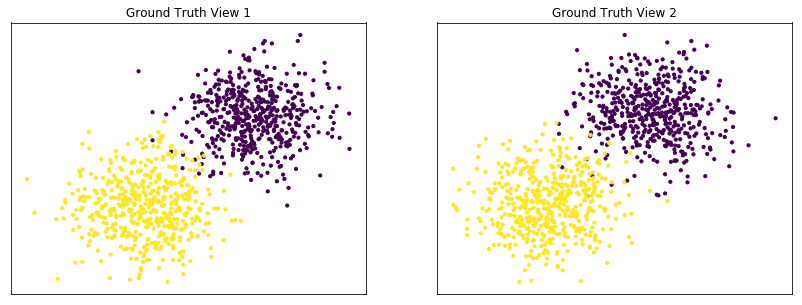

In [5]:
v1_means = [[3, 3], [0, 0]]
v2_means = [[3, 3], [0, 0]]
v1_vars = [1, 1]
v2_vars = [1, 1]
vmeans = [v1_means, v2_means]
vvars = [v1_vars, v2_vars]

data, labels = create_data(RANDOM_SEED, vmeans, vvars)
m_clusters = perform_clustering(RANDOM_SEED, data, labels, 2)
display_plots('Ground Truth' ,data, labels)

##### Performance when cluster components are relatively inseparable (highly overlapping) in both views

Cluster components 1:
* Mean: [0.5, 0.5] (both views)
* Covariance = I (both views)

Cluster components 2:
* Mean = [0, 0] (both views)
* Covariance = I (both views)

As we can see, multi-view kmeans clustering performs about as poorly as single-view kmeans clustering across both individual views and concatenaged views as inputs.

Single-view View 1 NMI Score: 0.425

Single-view View 2 NMI Score: 0.410

Single-view Concatenated NMI Score: 0.657

Multi-view NMI Score: 0.632



<Figure size 432x288 with 0 Axes>

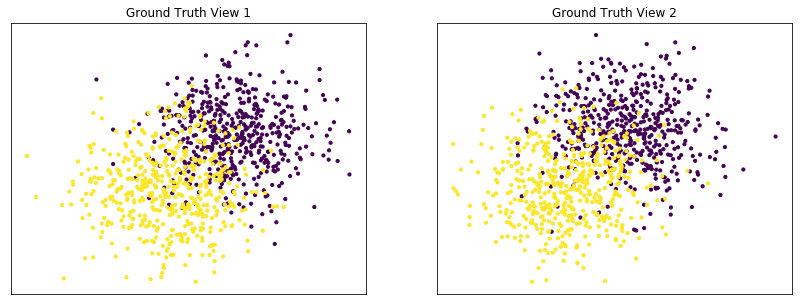

<Figure size 432x288 with 0 Axes>

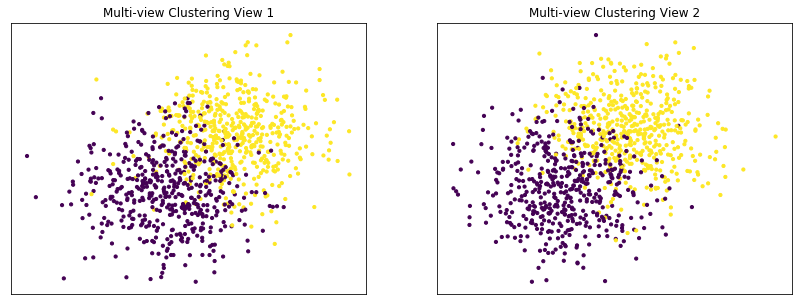

In [6]:
v1_means = [[1.5, 1.5], [0, 0]]
v2_means = [[1.5, 1.5], [0, 0]]
v1_vars = [1, 1]
v2_vars = [1, 1]
vmeans = [v1_means, v2_means]
vvars = [v1_vars, v2_vars]

data, labels = create_data(RANDOM_SEED, vmeans, vvars)
m_clusters = perform_clustering(RANDOM_SEED, data, labels, 2)
display_plots('Ground Truth' ,data, labels)
display_plots('Multi-view Clustering' ,data, m_clusters)

##### Performance when cluster components are somewhat separable (somewhat overlapping) in both views

Cluster components 1:
* Mean: [1.5, 1.5] (both views)
* Covariance = I (both views)

Cluster components 2:
* Mean = [0, 0] (both views)
* Covariance = I (both views)


Again we can see that multi-view kmeans clustering performs about as well as single-view kmeans clustering for the concatenated views, and both of these perform better than on single-view clustering for just one view. 

Single-view View 1 NMI Score: 0.425

Single-view View 2 NMI Score: 0.410

Single-view Concatenated NMI Score: 0.657

Multi-view NMI Score: 0.632



<Figure size 432x288 with 0 Axes>

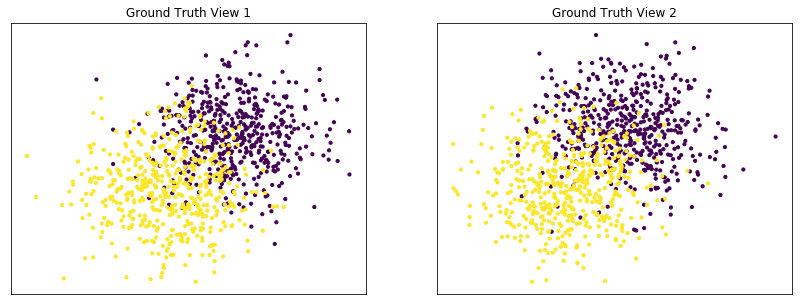

<Figure size 432x288 with 0 Axes>

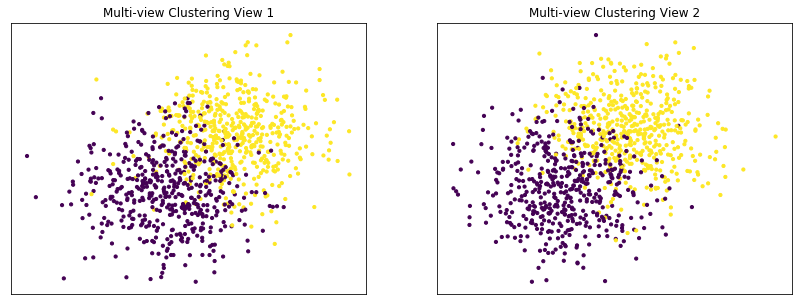

In [7]:
v1_means = [[1.5, 1.5], [0, 0]]
v2_means = [[1.5, 1.5], [0, 0]]
v1_vars = [1, 1]
v2_vars = [1, 1]
vmeans = [v1_means, v2_means]
vvars = [v1_vars, v2_vars]

data, labels = create_data(RANDOM_SEED, vmeans, vvars)
m_clusters = perform_clustering(RANDOM_SEED, data, labels, 2)
display_plots('Ground Truth' ,data, labels)
display_plots('Multi-view Clustering' ,data, m_clusters)

##### Performance when cluster components are highly overlapping in one view

Cluster components 1:
* Mean: View 1 = [0.5, 0.5], View 2 = [2, 2] 
* Covariance = I (both views)

Cluster components 2:
* Mean = [0, 0] (both views)
* Covariance = I (both views)

As we can see, multi-view kmeans clustering performs worse than single-view kmeans clustering with concatenaged views as inputs and with the best view as the input.

Single-view View 1 NMI Score: 0.062

Single-view View 2 NMI Score: 0.608

Single-view Concatenated NMI Score: 0.616

Multi-view NMI Score: 0.591



<Figure size 432x288 with 0 Axes>

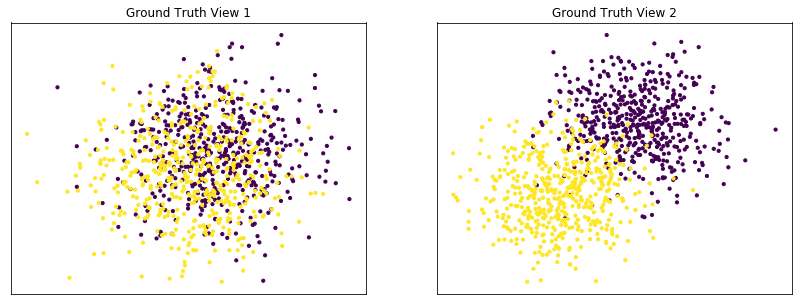

<Figure size 432x288 with 0 Axes>

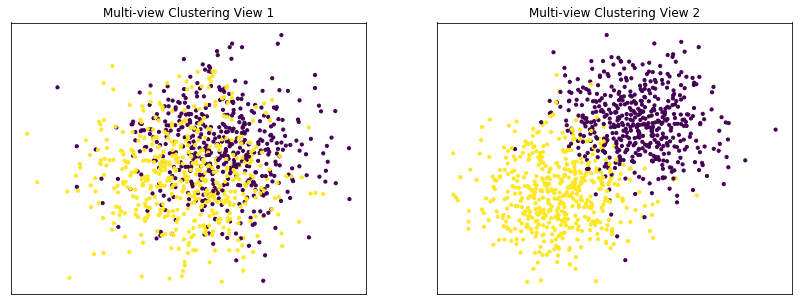

In [8]:
v1_means = [[0.5, 0.5], [0, 0]]
v2_means = [[2, 2], [0, 0]]
v1_vars = [1, 1]
v2_vars = [1, 1]
vmeans = [v1_means, v2_means]
vvars = [v1_vars, v2_vars]

data, labels = create_data(RANDOM_SEED, vmeans, vvars)
m_clusters = perform_clustering(RANDOM_SEED, data, labels, 2)
display_plots('Ground Truth' ,data, labels)
display_plots('Multi-view Clustering' ,data, m_clusters)

##### Conclusions

Here, we have seen some of the limitations of multi-view kmeans clustering. From the experiments above, it is apparent that multi-view kmeans clustering performs equally as well or worse than single-view kmeans clustering on concatenated data when views are informative but the data is fairly simple (i.e. only has 2 features per view). However, it is clear that the multi-view kmeans algorithm does perform better on well separated cluster components than it does on highly overlapping cluster components, which does validate it's basic functionality as a clustering algorithm. 